# Vector analogies in gene embeddings

It is quite possible that we can learn a lot about genes by looking at their embeddings.

## 

In [2]:

import os
import json
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

import requests
import time 
import anndata as ad

from tqdm import tqdm

from data.dataloaders import load_geneformer_embeddings, load_word2vec_embeddings  # Import custom data loading functions


In [3]:
emb, words = load_geneformer_embeddings("/home/benjami/barseq-transformer/gene_embeddings/data", reordered=False)


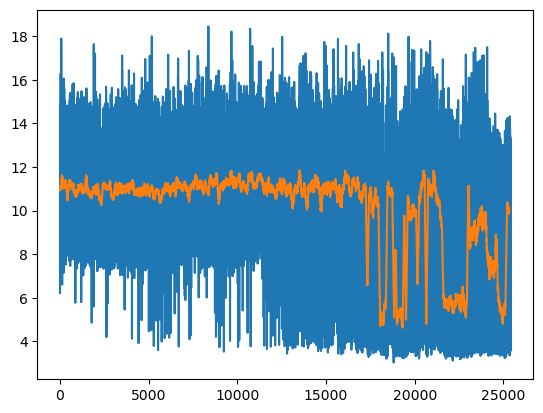

In [4]:
plt.plot(np.linalg.norm(emb, axis=1))

# a moving average of the norm of the embeddings
plt.plot(np.convolve(np.linalg.norm(emb, axis=1), np.ones(100)/100, mode='valid'))

Why is there this odd drop? Perhaps the norm correlates to mean expression level? Let's check that.

In [5]:
path = "/home/benjami/mnt/zador_data_norepl/Ari/transcriptomics/cellxgene/human/siletti_human_2022.h5ad"
adata = ad.read_h5ad(path, backed="r")




In [6]:
from scipy.sparse import csc_matrix

shared = set(adata.var_names) & set(words)

adata = adata[:, list(shared)]

X = csc_matrix(adata.X)


AttributeError: 'csc_matrix' object has no attribute 'getmmz'

In [9]:
adata2 = ad.AnnData(X, obs=adata.obs, var=adata.var)

nnz = X.getnnz(axis=0)
adata2.var["nnz"] = nnz.reshape(-1)
adata2.var["sum"] = X.sum(axis=0).A1



In [25]:
idx = np.argsort(adata2.var["nnz"])[::-1]
emb_dict = {w:e for w, e in zip(words, emb)}
emb_reordered = np.array([emb_dict[w] for w in adata2.var_names[idx]])

Text(0, 0.5, 'Embedding norm')

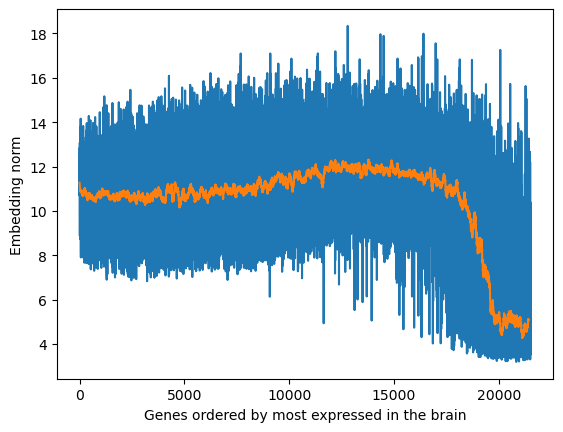

In [27]:

plt.plot(np.linalg.norm(emb_reordered, axis=1))

# a moving average of the norm of the embeddings
plt.plot(np.convolve(np.linalg.norm(emb_reordered, axis=1), np.ones(100)/100, mode='valid'))

plt.xlabel("Genes ordered by most expressed in the brain")
plt.ylabel("Embedding norm")


In [55]:
48*12

576

Wow. Very similar trend. Let's save this ordering.

In [33]:
from collections import OrderedDict
import json
import numpy as np


# Convert NumPy arrays to lists and float32 to float64
sorted_emb_dict = OrderedDict({str(w):emb_dict[w].tolist() if isinstance(emb_dict[w], np.ndarray) else float(emb_dict[w]) for w in adata2.var_names[idx]})

with open("/home/benjami/barseq-transformer/gene_embeddings/data/geneformer/gene_embeddings_ordered_brain.json", "w") as f:
    json.dump(sorted_emb_dict, f)


In [34]:
#load the descriptions
with open("/home/benjami/barseq-transformer/gene_embeddings/data/geneformer/gene_descriptions.json", "r") as f:
    gene_descriptions = json.load(f)

gene_descriptions_reordered = {g: gene_descriptions[g] for g in adata2.var_names[idx]}

with open("/home/benjami/barseq-transformer/gene_embeddings/data/geneformer/gene_descriptions_ordered_brain.json", "w") as f:
    json.dump(gene_descriptions_reordered, f)

# Geneformer

In [2]:
embeddings_adata = ad.read_h5ad("gene_embeddings.h5ad")
embeddings = embeddings_adata.X
embeddings_dict = {name: embeddings[i] for i, name in enumerate(embeddings_adata.obs.index)}
all_genes = embeddings_adata.obs.index

In [17]:
embeddings_adata[embeddings_adata.obs['leiden']=='23']

View of AnnData object with n_obs × n_vars = 394 × 512
    obs: 'leiden'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

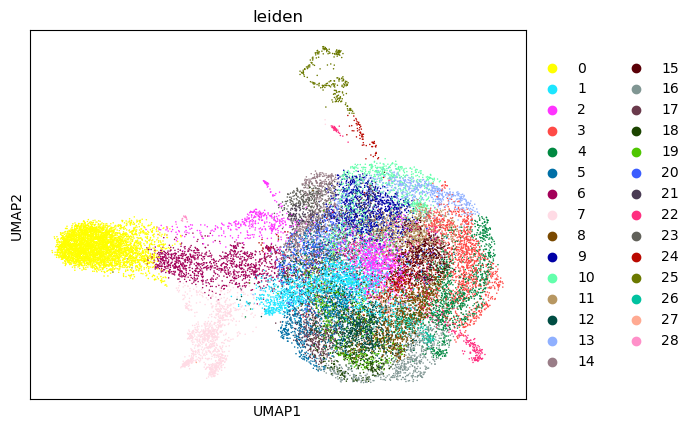

In [21]:
sc.pl.umap(embeddings_adata , color='leiden')


## Look at what genes are similar to what other genes

### Convenience functions

In [22]:

from sklearn.metrics.pairwise import cosine_similarity

def try_and_wait(n,headers):
    success = False
    while not success:
        r = requests.get(n,headers=headers)
        if r.status_code == 429:
            seconds_to_wait = int(r.headers["Retry-After"])
            time.sleep(seconds_to_wait)
        else:
            success = True
    return r

def get_gene_description_dir(ensembl_id):
    server = "https://rest.ensembl.org"
    ext = f"/lookup/id/{ensembl_id}?content-type=application/json"
    r = try_and_wait(server+ext, headers={ "Content-Type" : "application/json"})
    if not r.ok:
        print(r)
        return None
    decoded = r.json()
    return decoded['description']

gene_descriptions = {}
def get_gene_description(ensembl_id):
    """A memoized function to get gene descriptions from Ensembl"""
    if ensembl_id not in gene_descriptions:
        gene_descriptions[ensembl_id] = get_gene_description_dir(ensembl_id)
    return gene_descriptions[ensembl_id]

if os.path.exists("gene_descriptions.json"):
    gene_descriptions = json.load(open("gene_descriptions.json"))
    def get_gene_description(ensembl_id):
        return gene_descriptions[ensembl_id]


def get_most_similar_genes(query_gene, embeddings_dict, embeddings, metric='cosine',n=10):
    query_embedding = embeddings_dict[query_gene]
    if metric=='cosine':
        similarities = cosine_similarity([query_embedding], embeddings)
        most_similar_genes = np.argsort(similarities[0])[::-1][:n]
    elif metric=='euclidean':
        distances = np.linalg.norm(embeddings - query_embedding, axis=1)
        most_similar_genes = np.argsort(distances)[:n]
    return most_similar_genes


#### Build gene description dictionary

In [ ]:
# if not os.path.exists("gene_descriptions.json"):
#     gene_descriptions = {}
#     for gene in all_genes:
#         if gene.startswith("ENSG"):
#             gene_descriptions[gene] = get_gene_description(gene)
#     with open("gene_descriptions.json", "w") as fp:
#         json.dump(gene_descriptions, fp)

### Get example genes from each Leiden cluster

In [23]:

for cluster in embeddings_adata.obs.leiden.cat.categories:
    idx = embeddings_adata.obs.leiden == cluster
    # 2. Get the top embedding dim for each cluster of genes
    cluster_embeddings = embeddings_adata[idx].X
    cluster_mean = np.mean(cluster_embeddings, axis=0)

    # Get the 5 most similar genes to the cluster mean using Euclidean distance
    dissimilarities = np.sum((embeddings[idx] - cluster_mean)**2, axis=1)
    most_similar_genes = np.argsort(dissimilarities)[:5]

    print(f"Genes in family {cluster}: ")
    for i, gene in enumerate(most_similar_genes):
        index_of_gene = np.arange(len(embeddings))[idx][gene]
        gene_name = all_genes[index_of_gene]
        print(f"       {gene_name} ({get_gene_description(gene_name)})")



Genes in family 0: 
       ENSG00000266015 (microRNA 4309 [Source:HGNC Symbol;Acc:HGNC:38336])
       ENSG00000283616 (microRNA 5683 [Source:HGNC Symbol;Acc:HGNC:43453])
<Response [400]>
       ENSG00000215616 (None)


KeyError: 'description'

In principle we could get these descriptions for all genes, and then use a language model to summarize them.

### get top 10 most similar genes to query_gene1 and query_gene2 using cosine similarity


In [5]:
# Choose a few interesting ion channels

query_gene1 = "ENSG00000273079" # GRIN2B glutamate ionotropic receptor NMDA type subunit 2B 
query_gene2 = "ENSG00000102057" # Potassium voltage-gated channel subfamily D member 1 [Source:HGNC Symbol;Acc:HGNC:6237]
query_gene3 = "ENSG00000069849" # ATPase Na+/K+ transporting subunit beta 3 [Source:HGNC Symbol;Acc:HGNC:806]


assert query_gene1 in embeddings_dict 
assert query_gene2 in embeddings_dict 

In [12]:

most_similar_genes1 = get_most_similar_genes(query_gene1, embeddings_dict, embeddings, metric='euclidean')
most_similar_genes2 = get_most_similar_genes(query_gene2, embeddings_dict, embeddings, metric='euclidean')
most_similar_genes3 = get_most_similar_genes(query_gene3, embeddings_dict, embeddings, metric='euclidean')

In [13]:
# Print the most similar genes
print("Most similar genes to query gene 1:")
for i, gene in enumerate(most_similar_genes1):
    print(f"{i+1}. {all_genes[gene]} ({get_gene_description(all_genes[gene])})", 
            "similarity:", cosine_similarity([embeddings_dict[query_gene1]], [embeddings_dict[all_genes[gene]]])[0][0])

print("Most similar genes to query gene 2:")
for i, gene in enumerate(most_similar_genes2):
    
    print(f"{i+1}. {all_genes[gene]} ({get_gene_description(all_genes[gene])})",
            "similarity:", cosine_similarity([embeddings_dict[query_gene2]], [embeddings_dict[all_genes[gene]]])[0][0])

print("Most similar genes to query gene 3:")
for i, gene in enumerate(most_similar_genes3):
    print(f"{i+1}. {all_genes[gene]} ({get_gene_description(all_genes[gene])})",
            "similarity:", cosine_similarity([embeddings_dict[query_gene3]], [embeddings_dict[all_genes[gene]]])[0][0])


Most similar genes to query gene 1:
1. ENSG00000273079 (glutamate ionotropic receptor NMDA type subunit 2B [Source:HGNC Symbol;Acc:HGNC:4586]) similarity: 0.9999999
2. ENSG00000164742 (adenylate cyclase 1 [Source:HGNC Symbol;Acc:HGNC:232]) similarity: 0.7676534
3. ENSG00000050030 (neurite extension and migration factor [Source:HGNC Symbol;Acc:HGNC:29433]) similarity: 0.7540122
4. ENSG00000161082 (CUGBP Elav-like family member 5 [Source:HGNC Symbol;Acc:HGNC:14058]) similarity: 0.7484279
5. ENSG00000104833 (tubulin beta 4A class IVa [Source:HGNC Symbol;Acc:HGNC:20774]) similarity: 0.7540075
6. ENSG00000184194 (G protein-coupled receptor 173 [Source:HGNC Symbol;Acc:HGNC:18186]) similarity: 0.75533944
7. ENSG00000163281 (glucosamine-6-phosphate deaminase 2 [Source:HGNC Symbol;Acc:HGNC:21526]) similarity: 0.73409474
8. ENSG00000105613 (microtubule associated serine/threonine kinase 1 [Source:HGNC Symbol;Acc:HGNC:19034]) similarity: 0.7412994


KeyboardInterrupt: 

## Analogy method 1: search for genes that are similar to the linear combination of 3 genes

In [82]:

import numpy as np
from scipy import linalg
import random
import heapq

class EfficientWordAnalogySolver:
    def __init__(self, embeddings, top_k=10, max_iterations=1000000, tolerance=1e-3, n_candidates=100):
        self.embeddings = embeddings
        self.words = list(embeddings.keys())
        self.word_vectors = np.array([embeddings[w] for w in self.words])
        self.word_vectors_normalized = self.word_vectors / np.linalg.norm(self.word_vectors, axis=1)[:, np.newaxis]
        self.top_k = top_k
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.n_candidates = n_candidates

    def find_analogies(self, query_word):
        if query_word not in self.embeddings:
            raise ValueError(f"Word '{query_word}' not found in embeddings.")

        # Find candidate words for gene2 based on cosine similarity
        query_vector = self.embeddings[query_word]
        similarities = self.word_vectors_normalized.dot(query_vector / np.linalg.norm(query_vector))
        candidate_indices = np.argsort(similarities)[::-1][1:self.n_candidates+1]  # Exclude the query word itself
        gene2_candidates = [self.words[idx] for idx in candidate_indices]

        analogies = []
        for iteration in range(self.max_iterations):
            if iteration % 1000 == 0:
                print(f"Iteration {iteration}/{self.max_iterations}")
                if len(analogies) > 0:
                    print(f"Current top analogy: {analogies[0][1]} ≈ {analogies[0][4][0]:.2f} * {analogies[0][2]} + {analogies[0][4][1]:.2f} * {analogies[0][3]} - {analogies[0][4][2]:.2f} * {analogies[0][5]}  (error: {analogies[0][0]:.4f})")
            
            # Select gene2 from candidates and randomly select gene3
            gene2 = random.choice(gene2_candidates)
            gene3 = random.choice([w for w in self.words if w not in {query_word, gene2}])
            
            coeffs, error, gene4 = self.solve_lp(query_word, gene2, gene3)
            
            if coeffs is not None and gene4 not in {query_word, gene2, gene3}:
                heapq.heappush(analogies, (-error, query_word, gene2, gene3, coeffs, gene4))
                if len(analogies) > self.top_k:
                    heapq.heappop(analogies)
                # print(f"Found analogy: {query_word} ≈ {coeffs[0]:.2f} * {gene2} + {coeffs[1]:.2f} * {gene3} - {coeffs[2]:.2f} * {gene4} (error: {error:.4f})")

            if len(analogies) == self.top_k and -analogies[0][0] < 0.1:
                break

        return sorted(analogies, key=lambda x: -x[0])

    def solve_lp(self, gene1, gene2, gene3):
        v1, v2, v3 = [self.embeddings[w] for w in (gene1, gene2, gene3)]
        
        # Solve for A and B using a faster method
        M = np.column_stack([v2, v3])
        A, B = linalg.lstsq(M, v1, cond=self.tolerance)[0]

        # Calculate the residual
        residual = v1 - (A*v2 + B*v3)

        # Find gene4 using vector similarity, ensuring it's different from gene1, gene2, and gene3
        similarities = self.word_vectors_normalized.dot(residual / np.linalg.norm(residual))
        sorted_indices = np.argsort(similarities)[::-1]
        for idx in sorted_indices:
            if self.words[idx] not in {gene1, gene2, gene3}:
                C_idx = idx
                break
        
        gene4 = self.words[C_idx]
        C = np.dot(residual, self.word_vectors[C_idx]) / np.dot(self.word_vectors[C_idx], self.word_vectors[C_idx])

        error = np.linalg.norm(v1 - (A*v2 + B*v3 - C*self.embeddings[gene4]))
        
        return (A, B, C), error, gene4

# Usage
solver = EfficientWordAnalogySolver(embeddings_dict)

# Query for a specific gene
top_analogies = solver.find_analogies(query_gene1)

for error, gene1, gene2, gene3, (A, B, C), gene4 in top_analogies:
    print(f"{gene1} ≈ {A:.2f} * {gene2} + {B:.2f} * {gene3} - {C:.2f} * {gene4}  (error: {error:.4f})")


Iteration 0/1000000
Iteration 1000/1000000
Current top analogy: ENSG00000273079 ≈ 0.35 * ENSG00000178222 + 0.39 * ENSG00000241322 - 0.21 * ENSG00000148303  (error: -8.6954)
Iteration 2000/1000000
Current top analogy: ENSG00000273079 ≈ 0.57 * ENSG00000164742 + 0.23 * ENSG00000172650 - 0.14 * ENSG00000183117  (error: -8.6090)
Iteration 3000/1000000
Current top analogy: ENSG00000273079 ≈ 0.45 * ENSG00000065320 + 0.27 * ENSG00000115556 - 0.17 * ENSG00000158869  (error: -8.6076)
Iteration 4000/1000000
Current top analogy: ENSG00000273079 ≈ 0.48 * ENSG00000158816 + 0.24 * ENSG00000188474 - 0.17 * ENSG00000151150  (error: -8.5700)
Iteration 5000/1000000
Current top analogy: ENSG00000273079 ≈ 0.38 * ENSG00000117598 + 0.46 * ENSG00000104833 - 0.14 * ENSG00000165323  (error: -8.5620)
Iteration 6000/1000000
Current top analogy: ENSG00000273079 ≈ 0.54 * ENSG00000164742 + 0.29 * ENSG00000162650 - 0.14 * ENSG00000183117  (error: -8.5606)
Iteration 7000/1000000
Current top analogy: ENSG00000273079 ≈ 

In [83]:
for error, gene1, gene2, gene3, (A, B, C), gene4 in top_analogies:
    print(f"{gene1} ≈ {A:.2f} * {gene2} + {B:.2f} * {gene3} - {C:.2f} * {gene4}  (error: {error:.4f})")

ENSG00000273079 ≈ 0.44 * ENSG00000164742 + 0.38 * ENSG00000158816 - 0.19 * ENSG00000148303  (error: -8.0122)
ENSG00000273079 ≈ 0.38 * ENSG00000165084 + 0.49 * ENSG00000164742 - 0.16 * ENSG00000158869  (error: -8.1438)
ENSG00000273079 ≈ 0.38 * ENSG00000165084 + 0.49 * ENSG00000164742 - 0.16 * ENSG00000158869  (error: -8.1438)
ENSG00000273079 ≈ 0.47 * ENSG00000164742 + 0.34 * ENSG00000180116 - 0.13 * ENSG00000165323  (error: -8.1618)
ENSG00000273079 ≈ 0.41 * ENSG00000104833 + 0.41 * ENSG00000158816 - 0.13 * ENSG00000165323  (error: -8.2014)
ENSG00000273079 ≈ 0.42 * ENSG00000104833 + 0.39 * ENSG00000065320 - 0.13 * ENSG00000165323  (error: -8.2056)
ENSG00000273079 ≈ 0.39 * ENSG00000065320 + 0.42 * ENSG00000104833 - 0.13 * ENSG00000165323  (error: -8.2056)
ENSG00000273079 ≈ 0.43 * ENSG00000158816 + 0.35 * ENSG00000177234 - 0.19 * ENSG00000148303  (error: -8.2153)
ENSG00000273079 ≈ 0.47 * ENSG00000065320 + 0.33 * ENSG00000165323 - 0.20 * ENSG00000148303  (error: -8.2285)
ENSG00000273079 ≈ 0

## analogy method 1.5: search for genes that have the same difference vector as the difference between 2 genes

In [17]:
"""ENSG00000006744 - ENSG00000162302 ≈ ENSG00000006744 - ENSG00000162302"""

# Describe the functions of these 4 genes
gene1_description = get_gene_description("ENSG00000006744")
gene2_description = get_gene_description("ENSG00000162302")
gene3_description = get_gene_description("ENSG00000006744")
gene4_description = get_gene_description("ENSG00000162302")

print(f"Analogy? {gene1_description} \n ≈  {gene2_description} \n + {gene3_description} \n -  {gene4_description}")


Analogy? elaC ribonuclease Z 2 [Source:HGNC Symbol;Acc:HGNC:14198] 
 ≈  ribosomal protein S6 kinase A4 [Source:HGNC Symbol;Acc:HGNC:10433] 
 + elaC ribonuclease Z 2 [Source:HGNC Symbol;Acc:HGNC:14198] 
 -  ribosomal protein S6 kinase A4 [Source:HGNC Symbol;Acc:HGNC:10433]


## Analogy method 2: sparse dictionary learning

In [7]:
V = np.load("dictionary_decomposition/V_5e-05_ball.npy")
U = np.load("dictionary_decomposition/U_5e-05_ball.npy")

is_used = np.count_nonzero(U,0) > 0
U_used = U[:,is_used]
V_used = V[:,is_used]

# Update an AnnData object
embeddings_adata.obsm["U"] = U_used
embeddings_adata.varm["V"] = V_used

### Inspect the meaning of certain dictionary elements

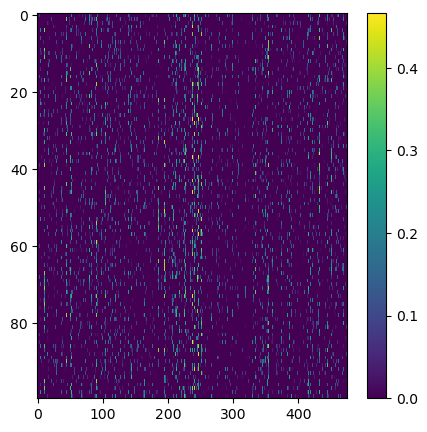

In [8]:
plt.figure(figsize=(5, 5))
plt.imshow(U_used[:100], aspect='auto', interpolation='none')
plt.colorbar()

In [45]:

for i in range(5):

    activation = U_used[:,i]
    top5_genes = np.argsort(activation)[::-1]
    top5_activation = activation[top5_genes]

    print(f"Top 5 genes for component {i} (mean activation {np.mean(activation)}; number of genes with activation > 0: {np.count_nonzero(U_used[:,i])}):")
    for j in range(5):
        gene = all_genes[top5_genes[j]]
        print(f"       {gene} ({get_gene_description(gene)}) - activation: {top5_activation[j]}")

Top 5 genes for component 0 (mean activation 0.029596291482448578; number of genes with activation > 0: 6148):
       ENSG00000188211 (natural killer cell cytotoxicity receptor 3 ligand 1 [Source:HGNC Symbol;Acc:HGNC:42400]) - activation: 0.24577394127845764
       ENSG00000139144 (phosphatidylinositol-4-phosphate 3-kinase catalytic subunit type 2 gamma [Source:HGNC Symbol;Acc:HGNC:8973]) - activation: 0.24553684890270233
       ENSG00000108797 (contactin associated protein 1 [Source:HGNC Symbol;Acc:HGNC:8011]) - activation: 0.24525143206119537
       ENSG00000108094 (cullin 2 [Source:HGNC Symbol;Acc:HGNC:2552]) - activation: 0.24510478973388672
       ENSG00000198198 (SZT2 subunit of KICSTOR complex [Source:HGNC Symbol;Acc:HGNC:29040]) - activation: 0.24505847692489624
Top 5 genes for component 1 (mean activation 0.010916401632130146; number of genes with activation > 0: 3750):
       ENSG00000111058 (acyl-CoA synthetase short chain family member 3 [Source:HGNC Symbol;Acc:HGNC:24723])

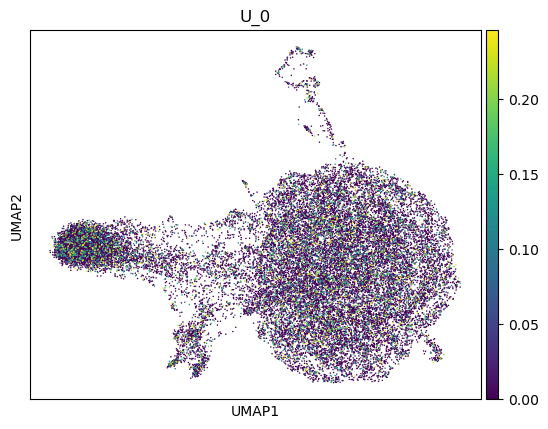

In [25]:
embeddings_adata.obs["U_0"] = U_used[:,0]
sc.pl.umap(embeddings_adata, color='U_0',)


### Analogies. 

An analogy occurs when the relationship between two pairs of genes is the same. Do any genes differ in just one way?

In [18]:
np.linalg.norm(embeddings_dict[query_gene1])

12.846333764793702

In [20]:
# For each dictionary element,
# 1. Add / subtract it from the query gene
# 2. Find the most similar genes to the result

def get_most_similar_genes_from_embedding(query_embedding, embeddings, metric='cosine',n=10):
    if metric=='cosine':
        similarities = cosine_similarity([query_embedding], embeddings)
        most_similar_genes = np.argsort(similarities[0])[::-1][:n]
    elif metric=='euclidean':
        distances = np.linalg.norm(embeddings - query_embedding, axis=1)
        most_similar_genes = np.argsort(distances)[:n]
    return most_similar_genes

query_genes = [query_gene1, query_gene2, query_gene3]
idx = [np.where(all_genes == gene)[0][0] for gene in query_genes]

for i in range(50):
    print(f"Dictionary element {i} (norm {np.linalg.norm(V_used[:,i])}):")
    dictionary_element = V_used[:,i]
    for j in idx:
        gene = all_genes[j]

        new_embedding = embeddings_dict[gene] + dictionary_element
        most_similar_genes = get_most_similar_genes_from_embedding(new_embedding, embeddings, metric='cosine',n=3)
        print(f"       {gene} ({get_gene_description(gene)})")
        print(f"           activation: {U_used[j,i]}")
        for k, similar_gene in enumerate(most_similar_genes):
            print(f"        ---> {all_genes[similar_gene]} ({get_gene_description(all_genes[similar_gene])})",
                    "similarity:", cosine_similarity([new_embedding], [embeddings[similar_gene]])[0][0])


Dictionary element 0 (norm 0.5584326386451721):
       ENSG00000273079 (glutamate ionotropic receptor NMDA type subunit 2B [Source:HGNC Symbol;Acc:HGNC:4586])
           activation: 0.19343197345733643
        ---> ENSG00000273079 (glutamate ionotropic receptor NMDA type subunit 2B [Source:HGNC Symbol;Acc:HGNC:4586]) similarity: 0.999413728271505
        ---> ENSG00000157470 (family with sequence similarity 81 member A [Source:HGNC Symbol;Acc:HGNC:28379]) similarity: 0.778044535018895
        ---> ENSG00000158816 (von Willebrand factor A domain containing 5B1 [Source:HGNC Symbol;Acc:HGNC:26538]) similarity: 0.7777562896467911
       ENSG00000102057 (potassium voltage-gated channel subfamily D member 1 [Source:HGNC Symbol;Acc:HGNC:6237])
           activation: 0.0
        ---> ENSG00000102057 (potassium voltage-gated channel subfamily D member 1 [Source:HGNC Symbol;Acc:HGNC:6237]) similarity: 0.9997057348339285
        ---> ENSG00000155666 (lysine demethylase 8 [Source:HGNC Symbol;Acc:H

In [9]:
# are there any U vectors that differ in only one gene?

from scipy.spatial.distance import pdist

embeddings_adata.obsm['U_binary'] = U_used > 0

# Calculate the Hamming distance between all pairs of U vectors
hamming_distances = pdist(embeddings_adata.obsm['U_binary'], metric='hamming')

# Convert Hamming distances to number of matching genes
n_components = U_used.shape[1]
differences = (hamming_distances * n_components)

In [11]:
differences.shape

(323228025,)

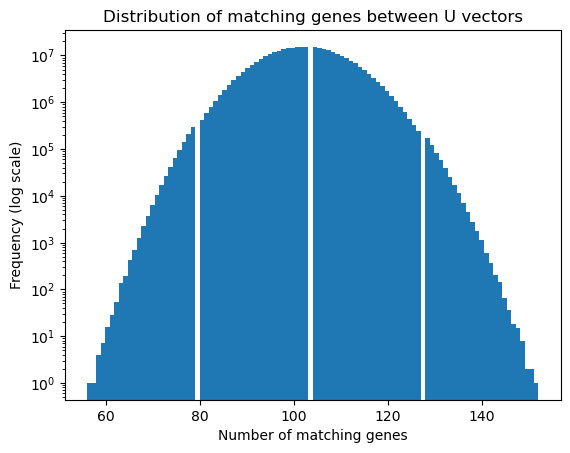

In [12]:

# Plot histogram
plt.hist(differences.flatten(), bins=100, log=True)
plt.xlabel('Number of matching genes')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of matching genes between U vectors')
plt.show()



### Pleiotropy: when do single genes have multiple dictionary elements?